# 5.0 scRepertoire in expanded experiment

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-27"

## Introduction

Use [scRepertoire](https://www.borch.dev/uploads/vignette/vignette) to explore clonotypes

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(decoupleR)
library(cowplot)
library(dplyr)
library(rlang)
library(pheatmap)
library(dittoSeq)}))

## Parameters

In [3]:
source(here("utils/bin.R"))
source(here("utils/style.R"))
source(here("SCGRES_124_125/sc_analysis/misc/paths.R"))

"{tcr}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{tcr}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

In [4]:
# depending on clone call
mode = "nt" 
chain = "TRB"

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.0.1-Annotation_Exp2.rds")))

In [6]:
metadata <- read.csv(here(glue("{cellranger}/metadata.csv")))

In [7]:
metadata <- subset(metadata, type == "VDJ-T" & timepoint == "Exp2")
metadata

,project,subproject,gem_id,library_id,library_name,library_barcode,hashing,type,donor_id,wet_lab,timepoint,replicate
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
4,SCGRES,SCGRES_124_125,41BBpos,301912,Tcells_41BBpos_TCR,BB1148,not_hashed,VDJ-T,Tcells_41BBpos_TCR,Tcells_41BBpos_TCR,Exp2,1
5,SCGRES,SCGRES_124_125,41BBneg,301913,Tcells_41BBneg_TCR,BB1149,not_hashed,VDJ-T,Tcells_41BBneg_TCR,Tcells_41BBneg_TCR,Exp2,1
6,SCGRES,SCGRES_124_125,41BBctr,301914,Tcells_41BB_ctr_TCR,BB1150,not_hashed,VDJ-T,Tcells_41BB_ctr_TCR,Tcells_41BB_ctr_TCR,Exp2,1


In [8]:
list_contigs <- lapply(unique(metadata$gem_id),function(lib) {
    print(lib)
    data <- read_csv(here(glue("{cellranger}/jobs/{lib}/{lib}/outs/per_sample_outs/{lib}/vdj_t/filtered_contig_annotations.csv")))
    data$timepoint <- "Exp2"
    data$replicate <- "1"
    data$sample_id <- lib
    data$sample_org <- lib
    data
})

[1] "41BBpos"


Rows: 2661 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "41BBneg"


Rows: 21232 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "41BBctr"


Rows: 18548 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
combined <- combineTCR(list_contigs,
                 samples = c("41BBpos", "41BBneg", "41BBctr"),
                 filterMulti = TRUE)

In [10]:
names(combined)<- c("41BBpos", "41BBneg", "41BBctr")

In [11]:
if (chain == "TRB") {
    if (mode == "strict") {
        combined <- lapply(names(combined), function(rep) {
            
            df <- combined[[rep]]
            df$TRB <- str_split(df$CTgene, "_", simplify = TRUE)[, 2]
            df$vj <-  sub(".[^.]+$", "",df$TRB)
            #remove D also
            df <- df %>%
                mutate(vj = sapply(vj, split_and_rejoin, separator = "[.]"))
            df$seq <- str_split(df$CTnt, "_", simplify = TRUE)[, 2]
            df <- df %>% 
                mutate(CTstrict = ifelse(is.na(vj) & is.na(seq), NA, paste(vj, seq, sep = "_")))
            df <- df[df[["CTstrict"]] != "NA_NA",]
            df
        })
    } else {
         combined <- lapply(names(combined), function(rep) {
            df <- combined[[rep]]
            df$CTgene <- str_split(df$CTgene, "_", simplify = TRUE)[, 2]
            df$CTnt <- str_split(df$CTnt, "_", simplify = TRUE)[, 2]
            df$CTaa <- str_split(df$CTaa, "_", simplify = TRUE)[, 2]
            df <- df[df[["CTgene"]] != "NA",]
            df <- df[df[["CTnt"]] != "NA",]
            df <- df[df[["CTaa"]] != "NA",]
            })
    } 
    combined <- setNames(combined, list("Exp1"))
}

In [12]:
seurat_tcr <- combineExpression(combined, seurat_obj, 
                  cloneCall = mode,        
                  proportion = FALSE, 
                  cloneTypes=c(Single=1, Small=5, Medium=20, Large=100, Hyperexpanded=500))

In [13]:
colorblind_vector <- colorRampPalette(rev(c("#0D0887FF", "#47039FFF", 
              "#7301A8FF", "#9C179EFF", "#BD3786FF", "#D8576BFF",
              "#ED7953FF","#FA9E3BFF", "#FDC926FF", "#F0F921FF")))

In [14]:
slot(seurat_tcr, "meta.data")$cloneType <- factor(slot(seurat_tcr, "meta.data")$cloneType, 
                levels = c("Hyperexpanded (100 < X <= 500)", 
                           "Large (20 < X <= 100)", 
                           "Medium (5 < X <= 20)", 
                           "Small (1 < X <= 5)", 
                           "Single (0 < X <= 1)", NA))
p_clono <- DimPlot(seurat_tcr, group.by = "cloneType",pt.size = 0.6) +
  labs(title=glue("Expansion level")) + theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = colorblind_vector(5), na.value="grey") +
    theme(legend.position = "bottom") +
    guides(color = guide_legend(nrow = 6, ncol=1,
                                  override.aes = list(size = 4)))

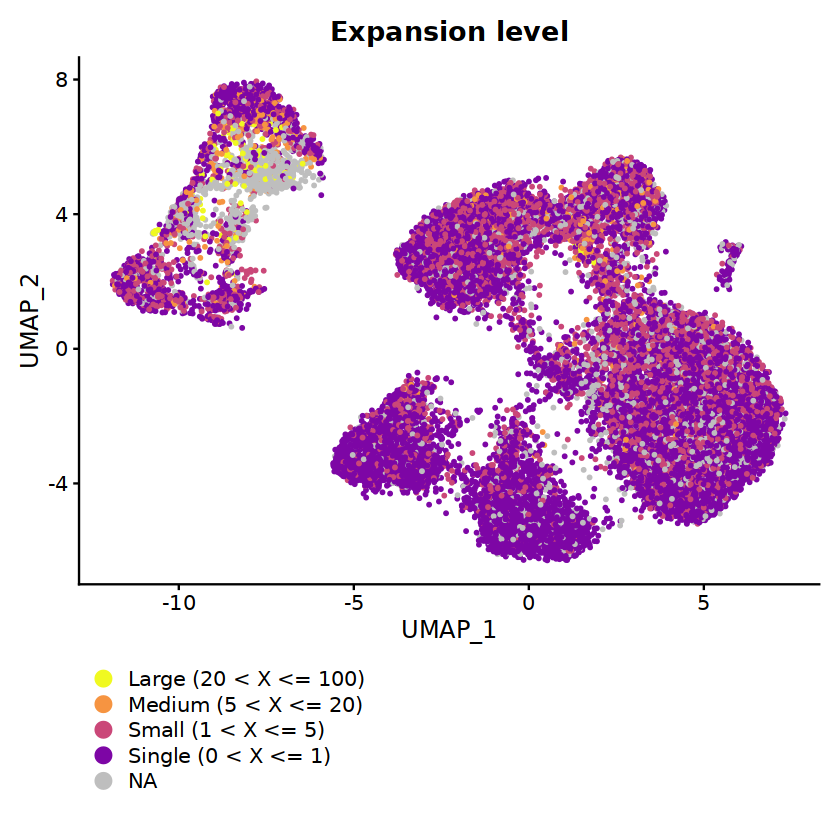

In [15]:
p_clono

In [16]:
seurat_tcr@meta.data$cdr3 <- substr(seurat_tcr@meta.data$CTnt, start = 3 + 1, stop = nchar(seurat_tcr@meta.data$CTnt) - 3)

In [17]:
double_b <- sum(grepl(";", seurat_tcr$CTnt))
single_b <- nrow(seurat_tcr@meta.data) - double_b

In [18]:
print(double_b)
print(single_b)

[1] 1
[1] 21818


In [19]:
saveRDS(seurat_tcr, here(glue("{tcr}/{robj_dir}/5.0-ExpTCR_{mode}_{chain}.rds")))

## Explore the top ones in the Expansion Experiment

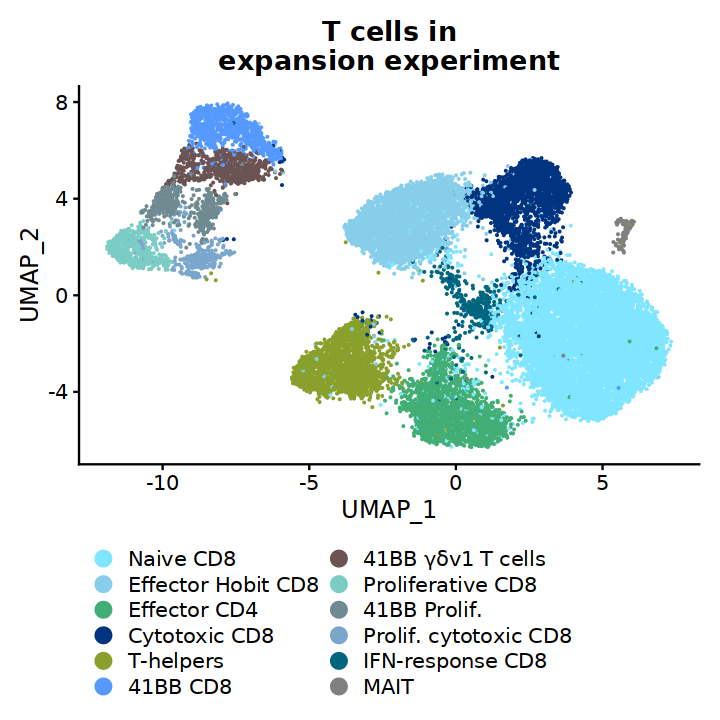

In [20]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
p_clust <- DimPlot(seurat_tcr, reduction = "umap", cols=exp_pal)+ 
  labs(title=glue("T cells in\nexpansion experiment"),
        label = T,
        label.box = TRUE,
        label.size = 3.5,
        repel = TRUE) + theme(plot.title = element_text(hjust = 0.5),
                                             legend.position = "bottom")+ 
       guides(color = guide_legend(ncol = 2,
                                  override.aes = list(size = 4))) 
p_clust

In [21]:
df_summary <- seurat_tcr@meta.data %>%
  filter(!is.na(cdr3)) %>%
  group_by(cdr3) %>%
  summarise(
    sample_id = list(unique(sample_id)),
    count = n()
  ) %>%
  filter(count > 1) %>%
  arrange(desc(count)) 

head(df_summary, n=20)

cdr3,sample_id,count
<chr>,<list>,<int>
GCCAGCAGCGTTGGACAGAAGAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",59
GCCAGCAGCTTGAAGTTAGCGGGAGGACCCTACGAGCAGTAC,"41BBctr, 41BBpos",53
GCTAGCAGCTTCCCAGGGCGGGGGAGATTTCCCGGGGAGCTGTTT,"41BBctr, 41BBneg, 41BBpos",45
GCCAGCAGTTTCGGAACAGGGGGTCTCGGGGAGACCCAGTAC,"41BBctr, 41BBneg, 41BBpos",36
GCCAGCAATTTCGGAAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",31
GCCAGCAGCCAAGATCGGGTATTTAGGACGCGGGAGACTACTAACTATGGCTACACC,41BBpos,28
GCCAGCAGCCAGCCGGGACAGCGCGGAAACACCATATAT,"41BBctr, 41BBneg, 41BBpos",21
GCCAGCAGAGGGGGAGGATCGGATTCACCCCTCCAC,41BBpos,20
GCCAGCAGCTTACAGGGGGCCCTCAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",19


In [22]:
source(here("SCGRES_124_125/sc_analysis/misc/paths.R"))
df_summary <- df_summary %>%
  mutate(sample_id = sapply(sample_id, function(x) paste(x, collapse = ", ")))
write_csv(df_summary, here(glue("{tcr}/{robj_dir}/5.0-TCRs_Exp2.csv")))

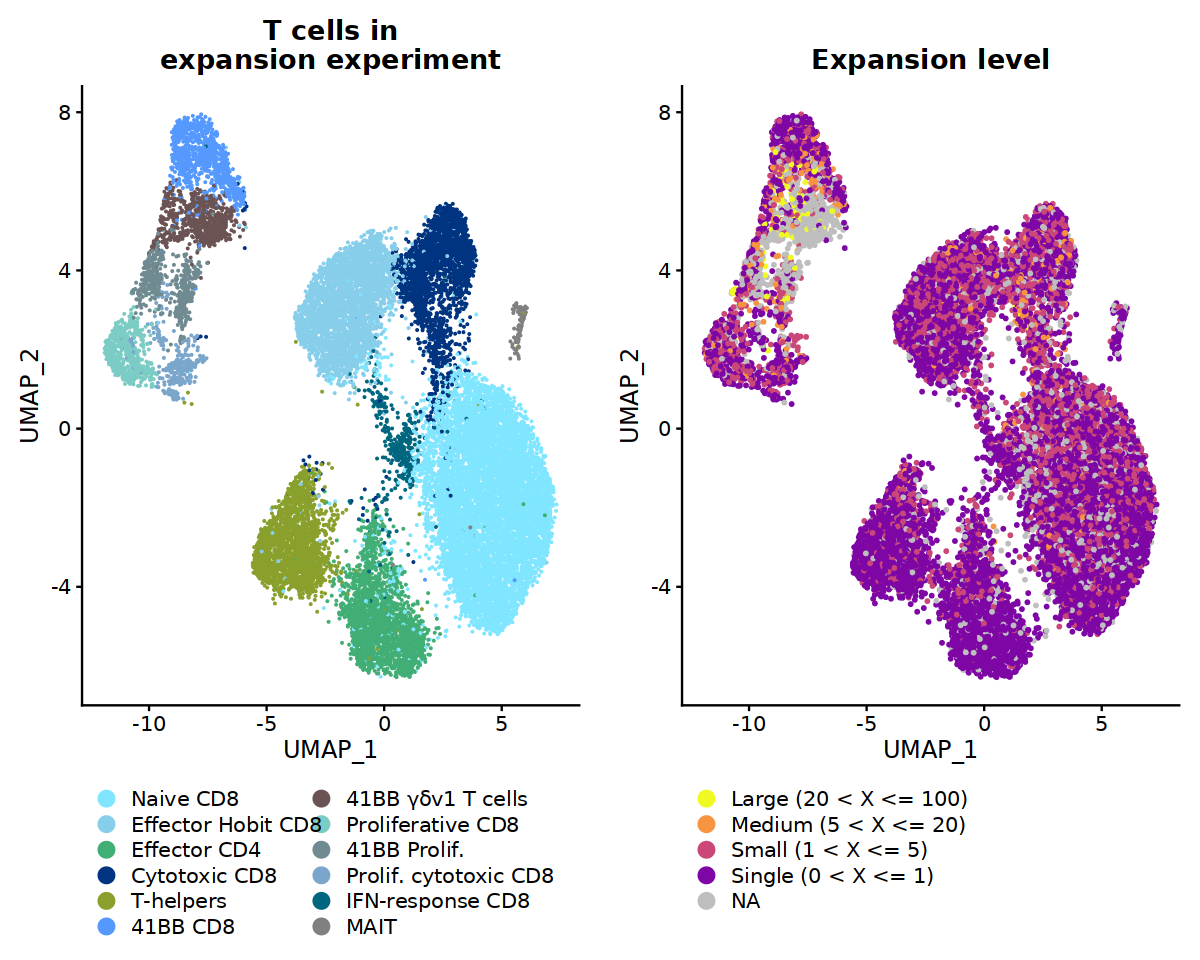

In [23]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list(p_clust, p_clono),
                   align = "hv",
                   axis = "trbl",
                   ncol = 2,
                   nrow = 1)
cp

Most abundant in 41BB positive fraction respect to the total of all three samples

In [24]:
df_pos <- df_summary %>%
  filter(str_detect(sample_id, as.character("pos"))) %>% head(n=30)
df_pos

cdr3,sample_id,count
<chr>,<chr>,<int>
GCCAGCAGCGTTGGACAGAAGAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",59
GCCAGCAGCTTGAAGTTAGCGGGAGGACCCTACGAGCAGTAC,"41BBctr, 41BBpos",53
GCTAGCAGCTTCCCAGGGCGGGGGAGATTTCCCGGGGAGCTGTTT,"41BBctr, 41BBneg, 41BBpos",45
GCCAGCAGTTTCGGAACAGGGGGTCTCGGGGAGACCCAGTAC,"41BBctr, 41BBneg, 41BBpos",36
GCCAGCAATTTCGGAAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",31
GCCAGCAGCCAAGATCGGGTATTTAGGACGCGGGAGACTACTAACTATGGCTACACC,41BBpos,28
GCCAGCAGCCAGCCGGGACAGCGCGGAAACACCATATAT,"41BBctr, 41BBneg, 41BBpos",21
GCCAGCAGAGGGGGAGGATCGGATTCACCCCTCCAC,41BBpos,20
GCCAGCAGCTTACAGGGGGCCCTCAATGGCTACACC,"41BBctr, 41BBneg, 41BBpos",19


Most counts in the positive 41BB fraction only

In [25]:
df_pos <- seurat_tcr@meta.data %>%
  filter(!is.na(cdr3)) %>%
  select(c("cdr3",  "Frequency", "sample_id")) %>%
  unique() %>%
  pivot_wider(id_cols=c("cdr3"),names_from = sample_id, values_from = Frequency, values_fill = 0) %>%
  arrange(desc(`41BBpos`))
df_pos

cdr3,41BBctr,41BBneg,41BBpos
<chr>,<int>,<int>,<int>
GCCAGCAGCTTGAAGTTAGCGGGAGGACCCTACGAGCAGTAC,1,0,52
GCTAGCAGCTTCCCAGGGCGGGGGAGATTTCCCGGGGAGCTGTTT,7,3,35
GCCAGCAGCCAAGATCGGGTATTTAGGACGCGGGAGACTACTAACTATGGCTACACC,0,0,28
GCCAGCAGAGGGGGAGGATCGGATTCACCCCTCCAC,0,0,20
GCCAGTAGTGCAGGACAGGGAAGTTTCGACACCGGGGAGCTGTTT,1,0,14
AGTGCATGGACTAGCGGGAGTCGTAGTTTTTACGAGCAGTAC,0,1,14
GCCAGCAGTCCCCGACCAGCCTACGAGCAGTAC,0,0,12
GCCAGTAGTACAGGGGCCCGCTGGCAAGAGACCCAGTAC,0,0,11
GCCACCAGTGTGAACGGGAGGGCCAGTGAGCAGTTC,2,0,10


In [26]:
df_tmp <- seurat_tcr@meta.data %>% 
    group_by(sample_id, cdr3) %>%
    summarise(
        count = n()) %>% 
    dplyr::filter(!is.na(cdr3)) %>%
    mutate(category = case_when(
        is.na(cdr3) ~ "noTCR",
        count == 1~ "singlet",
        count > 20  ~ "X > 20",
        count > 10 & count <= 20 ~ "10 < X <= 20",
        count > 5 & count <= 10 ~ "5 < X <= 10",
        count > 1 & count <= 5 ~ "1 < X <= 5")) %>%
    arrange(desc(count)) 

In [27]:
totals <- as.data.frame(table(seurat_tcr@meta.data$sample_id))
colnames(totals) <- c("timpoint", "total")

In [28]:
df_plot2 <- df_tmp %>%
  group_by(sample_id, category) %>%
  summarise(count = n()) %>%
   arrange(desc(sample_id)) 
df_plot2

sample_id,category,count
<chr>,<chr>,<int>
41BBpos,1 < X <= 5,129
41BBpos,10 < X <= 20,5
41BBpos,5 < X <= 10,14
41BBpos,X > 20,3
41BBpos,singlet,672
41BBneg,1 < X <= 5,1140
41BBneg,10 < X <= 20,2
41BBneg,5 < X <= 10,19
41BBneg,singlet,6901


In [29]:
df_plot2$category <- factor(df_plot2$category, levels = rev(c("noTCR", "singlet",
                                                              "1 < X <= 5", 
                                                              "5 < X <= 10", 
                                                              "10 < X <= 20", 
                                                              "X > 20")))
df_plot2$sample_id <- factor(df_plot2$sample_id, levels = unique(df_plot2$sample_id))

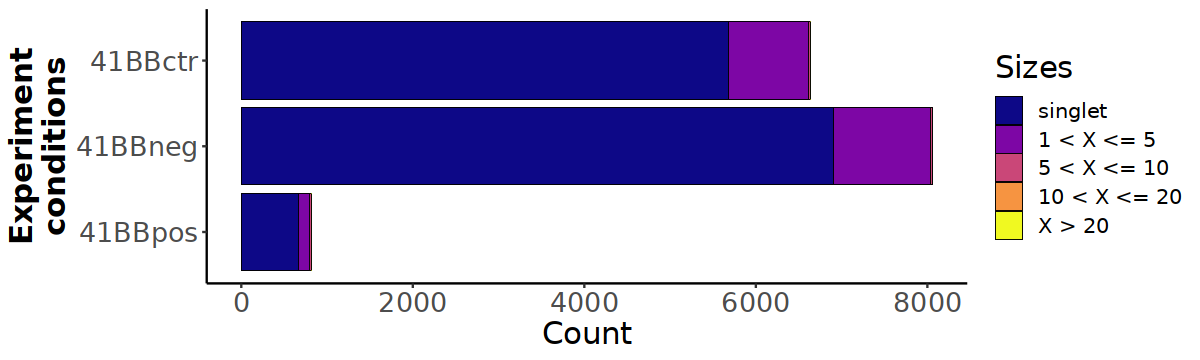

In [30]:
options(repr.plot.width = 10, repr.plot.height = 3, warn=-1,verbose = FALSE)
    plt <- ggplot(df_plot2, aes_string(x = "sample_id", y = "count", fill = "category")) +
      geom_bar(stat = "identity",colour = "black",size = 0.2) +

      labs(#title = "Clonotype sizes",
           x = "Experiment\nconditions",
           y = "Count",
           fill = "Sizes") +
           scale_fill_manual(breaks = c("singlet",
                                        "1 < X <= 5", 
                                        "5 < X <= 10", 
                                        "10 < X <= 20", 
                                        "X > 20"),
                             values = rev(colorblind_vector(5))) + 
      theme_classic() +
      theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
            axis.text.x = element_text(size = 16), 
            axis.title.y = element_text(size = 18, face="bold"), 
            axis.text.y = element_text(size = 16),
            text = element_text(size = 18),
            legend.text = element_text(size = 12)) + coord_flip()
    
    plt

In [31]:
df_plot3 <- df_plot2 %>%
    filter(category != "singlet") %>%
    group_by(sample_id) %>%
    mutate(prop = count/sum(count)) %>%
    ungroup()

df_plot3$sample_id <- factor(df_plot3$sample_id, levels = unique(rev(df_plot3$sample_id)))

In [32]:
rev(colorblind_vector(5))

[1] "#0D0887" "#7D06A5" "#CA4778" "#F69441" "#F0F921"

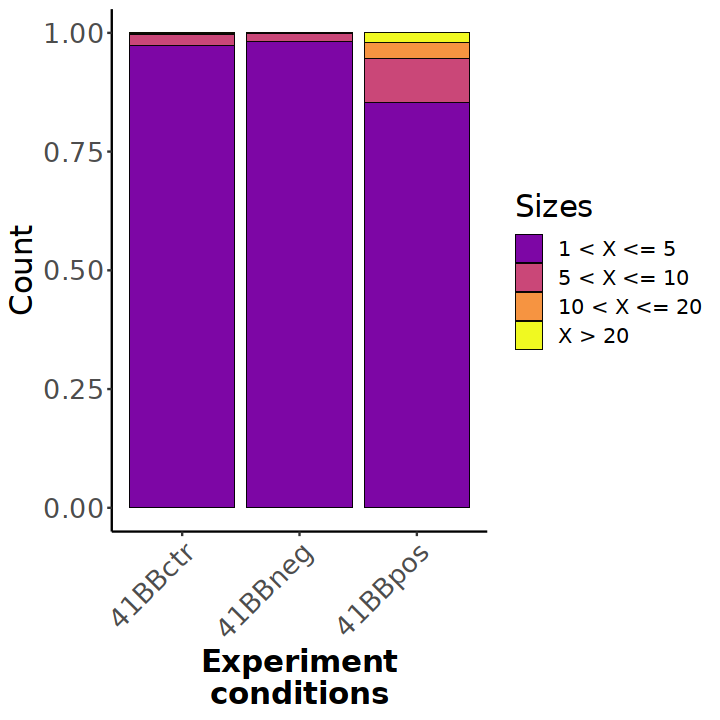

In [33]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
    plt <- ggplot(df_plot3, aes_string(x = "sample_id", y = "prop", fill = "category")) +
      geom_bar(stat = "identity",colour = "black",size = 0.2) +

      labs(#title = "Clonotype sizes",
           x = "Experiment\nconditions",
           y = "Count",
           fill = "Sizes") +
           scale_fill_manual(breaks = c("1 < X <= 5", 
                                        "5 < X <= 10", 
                                        "10 < X <= 20", 
                                        "X > 20"),
                             values = c('#7D06A5','#CA4778','#F69441','#F0F921')) + 
      theme_classic() +
      theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
            axis.text.x = element_text(size = 16, angle = 45, vjust = 1, hjust=1), 
            axis.title.y = element_text(size = 18),
            axis.title.x = element_text(size = 18,face="bold"),
            axis.text.y = element_text(size = 16),
            text = element_text(size = 18),
            legend.text = element_text(size = 12)) 
    
    plt

In [34]:
ggsave(plot = plt, width = 6, height = 6, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.0-exp_clono_size.svg")))

In [35]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] dittoSeq_1.6.0      pheatmap_1.0.12     rlang_1.1.1        
 [4] cowplot_1.1.1       decoupleR_2.9.1     lubridate_1.9.3    
 [7] forcats_1.0.0       stringr_1.5.0       dplyr_1.1.3        
[10] purrr_1.0.2         readr_2.1.4         tidyr_1.3.0        
[13] tibble_3.2.1    